# Valuation Model 

### Import Packages

In [46]:
# Import external packages
from scipy.stats import norm
import numpy as np
import pandas as pd
import requests
import yfinance as yf
import matplotlib.pyplot as plt
import numpy_financial as npf
from scipy.stats import norm
import seaborn as sns
import statsmodels.api as sm
from IPython.display import display, HTML
from IPython.display import display, Math
from dotenv import load_dotenv
import os
%matplotlib inline

In [47]:
ticker = 'UNH'
data = yf.Ticker(ticker)

## EXTRACT FINANCIAL STATEMENTS 

In [48]:
# Configure pandas to avoid scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)

def safe_loc(df, label):
    """
    Safely locate a row in DataFrame by partial label (case-insensitive).
    Returns a Series with zeros if not found.
    """
    for idx in df.index:
        if label.lower() in idx.lower():
            return df.loc[idx]
    return pd.Series([0] * df.shape[1], index=df.columns)

def add_stats_columns(df):
    """
    Add Mean and Std Dev columns calculated from year columns (digits only) and TTM.
    Reorder columns to have TTM and years first, then Mean and Std Dev.
    """
    year_cols = [col for col in df.columns if col.isdigit() or col == 'TTM']
    df['Mean'] = df[year_cols].mean(axis=1)
    df['Std Dev'] = df[year_cols].std(axis=1)
    new_order = ['TTM'] + sorted([col for col in year_cols if col != 'TTM']) + ['Mean', 'Std Dev']
    # Only keep columns that exist in the DataFrame to avoid KeyError
    existing_cols = [col for col in new_order if col in df.columns]
    df = df[existing_cols]
    return df

def get_financial_data(ticker):
    """
    Retrieves and processes Income Statement, Balance Sheet, and Cash Flow data
    for the given ticker symbol, including growth calculations, summary stats, and TTM.
    """
    stock = yf.Ticker(ticker)
    financials = stock.financials
    balance_sheet = stock.balance_sheet
    cash_flow = stock.cashflow
    quarterly_financials = stock.quarterly_financials
    quarterly_balance_sheet = stock.quarterly_balance_sheet
    quarterly_cashflow = stock.quarterly_cashflow

    # Dates to filter columns (modify if needed)
    target_dates = ['2024-12-31', '2023-12-31', '2022-12-31', '2021-12-31']
    fin_years = [y for y in target_dates if y in financials.columns]
    bal_years = [y for y in target_dates if y in balance_sheet.columns]
    cf_years = [y for y in target_dates if y in cash_flow.columns]

    # Calculate TTM data
    ttm_data_is = {}
    ttm_data_bs = {}
    ttm_data_cf = {}
    if not quarterly_financials.empty:
        last_4_quarters = quarterly_financials.iloc[:, :4]  # Last 4 quarters for TTM
        ttm_data_is['Sales'] = last_4_quarters.loc['Total Revenue'].sum() if 'Total Revenue' in last_4_quarters.index else 0
        ttm_data_is['COGS'] = last_4_quarters.loc['Cost Of Revenue'].sum() if 'Cost Of Revenue' in last_4_quarters.index else 0
        ttm_data_is['Operating Expenses'] = last_4_quarters.loc['Operating Expense'].sum() if 'Operating Expense' in last_4_quarters.index else 0
        ttm_data_is['EBIT'] = last_4_quarters.loc['Operating Income'].sum() if 'Operating Income' in last_4_quarters.index else 0
        ttm_data_is['Interest Expense'] = last_4_quarters.loc['Interest Expense'].sum() if 'Interest Expense' in last_4_quarters.index else 0
        ttm_data_is['Depreciation'] = safe_loc(cash_flow, 'Depreciation Amortization Depletion')[cf_years].sum() if 'Depreciation Amortization Depletion' in cash_flow.index else 0
        ttm_data_is['Pretax Income'] = last_4_quarters.loc['Pretax Income'].sum() if 'Pretax Income' in last_4_quarters.index else 0
        ttm_data_is['Tax Provision'] = last_4_quarters.loc['Tax Provision'].sum() if 'Tax Provision' in last_4_quarters.index else 0
        ttm_data_is['Net Income'] = last_4_quarters.loc['Net Income'].sum() if 'Net Income' in last_4_quarters.index else 0
        ttm_data_is['EPS'] = stock.info.get('trailingEps', 0)
        ttm_data_is['Shares Outstanding'] = safe_loc(financials, 'Diluted Average Shares')[fin_years].iloc[0] if 'Diluted Average Shares' in financials.index else 0
        ttm_data_is['Revenue Per Share'] = ttm_data_is['Sales'] / ttm_data_is['Shares Outstanding'] if ttm_data_is['Shares Outstanding'] != 0 else 0
        ttm_data_is['Effective Tax Rate'] = ttm_data_is['Tax Provision'] / ttm_data_is['Pretax Income'] if ttm_data_is['Pretax Income'] != 0 else 0

    if not quarterly_balance_sheet.empty:
        ttm_data_bs['Total Assets'] = quarterly_balance_sheet.loc['Total Assets'].iloc[0] if 'Total Assets' in quarterly_balance_sheet.index else 0
        ttm_data_bs['Current Assets'] = quarterly_balance_sheet.loc['Current Assets'].iloc[0] if 'Current Assets' in quarterly_balance_sheet.index else 0
        ttm_data_bs['Non-Current Assets'] = ttm_data_bs['Total Assets'] - ttm_data_bs['Current Assets']
        ttm_data_bs['Total Liabilities'] = quarterly_balance_sheet.loc['Total Liabilities Net Minority Interest'].iloc[0] if 'Total Liabilities Net Minority Interest' in quarterly_balance_sheet.index else 0
        ttm_data_bs['Current Liabilities'] = quarterly_balance_sheet.loc['Current Liabilities'].iloc[0] if 'Current Liabilities' in quarterly_balance_sheet.index else 0
        ttm_data_bs['Non-Current Liabilities'] = ttm_data_bs['Total Liabilities'] - ttm_data_bs['Current Liabilities']
        ttm_data_bs['Total Equity'] = quarterly_balance_sheet.loc['Common Stock Equity'].iloc[0] if 'Common Stock Equity' in quarterly_balance_sheet.index else 0
        ttm_data_bs['Total Debt'] = quarterly_balance_sheet.loc['Total Debt'].iloc[0] if 'Total Debt' in quarterly_balance_sheet.index else 0
        ttm_data_bs['Working Capital'] = quarterly_balance_sheet.loc['Working Capital'].iloc[0] if 'Working Capital' in quarterly_balance_sheet.index else 0
        ttm_data_bs['Shares Outstanding'] = ttm_data_is['Shares Outstanding']  # Reuse from IS
        ttm_data_bs['Book Value'] = quarterly_balance_sheet.loc['Total Equity Gross Minority Interest'].iloc[0] if 'Total Equity Gross Minority Interest' in quarterly_balance_sheet.index else 0
        ttm_data_bs['Book Value per Share'] = ttm_data_bs['Book Value'] / ttm_data_bs['Shares Outstanding'] if ttm_data_bs['Shares Outstanding'] != 0 else 0

    if not quarterly_cashflow.empty:
        last_4_quarters_cf = quarterly_cashflow.iloc[:, :4]
        ttm_data_cf['EBIT'] = ttm_data_is['EBIT']  # Reuse from IS
        ttm_data_cf['Operating Cash Flow'] = last_4_quarters_cf.loc['Operating Cash Flow'].sum() if 'Operating Cash Flow' in last_4_quarters_cf.index else 0
        ttm_data_cf['CAPEX'] = last_4_quarters_cf.loc['Capital Expenditure'].sum() if 'Capital Expenditure' in last_4_quarters_cf.index else 0
        ttm_data_cf['Free Cash Flow'] = last_4_quarters_cf.loc['Free Cash Flow'].sum() if 'Free Cash Flow' in last_4_quarters_cf.index else 0

    # ========== INCOME STATEMENT ==========
    sales = safe_loc(financials, 'Total Revenue')[fin_years].astype(float)
    cogs = safe_loc(financials, 'Cost of Revenue')[fin_years].astype(float)
    operating_expense = safe_loc(financials, 'Operating Expense')[fin_years].astype(float)
    ebit = safe_loc(financials, 'Operating Income')[fin_years].astype(float)
    interest_expense = safe_loc(financials, 'Interest Expense')[fin_years].astype(float)
    depreciation = safe_loc(cash_flow, 'Depreciation Amortization Depletion')[cf_years].astype(float)
    pretax_income = safe_loc(financials, 'Pretax Income')[fin_years].astype(float)
    tax_provision = safe_loc(financials, 'Tax Provision')[fin_years].astype(float)
    net_income = safe_loc(financials, 'Net Income')[fin_years].astype(float)
    eps = safe_loc(financials, 'Diluted EPS')[fin_years].astype(float)
    shares_outstanding = safe_loc(financials, 'Diluted Average Shares')[fin_years].astype(float)
    revenue_per_share = (sales / shares_outstanding).astype(float)
    tax_rate = (tax_provision / pretax_income).replace([np.inf, -np.inf], 0).fillna(0).astype(float)

    income_statement = pd.DataFrame({
        "Sales": sales,
        "COGS": cogs,
        "Operating Expenses": operating_expense,
        "EBIT": ebit,
        "Interest Expense": interest_expense,
        "Depreciation": depreciation,
        "Pretax Income": pretax_income,
        "Tax Provision": tax_provision,
        "Net Income": net_income,
        "EPS": eps,
        "Shares Outstanding": shares_outstanding,
        "Revenue Per Share": revenue_per_share,
        "Effective Tax Rate": tax_rate
    }).T

    income_statement.columns = [str(pd.to_datetime(y).year) for y in income_statement.columns]
    income_statement['TTM'] = pd.Series({idx: ttm_data_is.get(idx, 0) for idx in income_statement.index}, index=income_statement.index)
    income_statement = income_statement[['TTM'] + sorted([col for col in income_statement.columns if col != 'TTM'])]

    # Calculate growth for Income Statement metrics with limited pairs
    growth_metrics_is = ["Sales", "Net Income", "EPS", "Shares Outstanding"]
    growth_rows_is = {}
    for metric in growth_metrics_is:
        values = income_statement.loc[metric][['2024', '2023', '2022', '2021']]
        growth = pd.Series([0.0, 0.0, 0.0, 0.0], index=['2021', '2022', '2023', '2024'])
        growth['2024'] = (values['2024'] - values['2023']) / values['2023'] if values['2023'] != 0 else 0
        growth['2023'] = (values['2023'] - values['2022']) / values['2022'] if values['2022'] != 0 else 0
        growth['2022'] = (values['2022'] - values['2021']) / values['2021'] if values['2021'] != 0 else 0
        growth['2021'] = 0.0  # No growth for 2021 since no 2020 data
        growth = growth.rename(f"{metric} Growth")
        growth_rows_is[growth.name] = growth
    growth_df_is = pd.DataFrame(growth_rows_is).T

    def interleave_with_growth(df, growth_df, metrics):
        rows = []
        for row in df.index:
            rows.append(row)
            growth_row = f"{row} Growth"
            if growth_row in growth_df.index:
                rows.append(growth_row)
        combined = pd.concat([df, growth_df])
        return combined.loc[rows]

    income_statement_combined = interleave_with_growth(income_statement, growth_df_is, growth_metrics_is)

    # ========== BALANCE SHEET ==========
    total_assets = safe_loc(balance_sheet, 'Total Assets')[bal_years].astype(float)
    current_assets = safe_loc(balance_sheet, 'Current Assets')[bal_years].astype(float)
    non_current_assets = total_assets - current_assets

    total_liabilities = safe_loc(balance_sheet, 'Total Liabilities Net Minority Interest')[bal_years].astype(float)
    current_liabilities = safe_loc(balance_sheet, 'Current Liabilities')[bal_years].astype(float)
    non_current_liabilities = total_liabilities - current_liabilities

    total_equity = safe_loc(balance_sheet, 'Common Stock Equity')[bal_years].astype(float)
    total_debt = safe_loc(balance_sheet, 'Total Debt')[bal_years].astype(float)
    working_capital = safe_loc(balance_sheet, 'Working Capital')[bal_years].astype(float)
    shares = shares_outstanding  # reuse shares outstanding from income statement

    book_value = safe_loc(balance_sheet, 'Total Equity Gross Minority Interest')[bal_years].astype(float)
    book_value_per_share = book_value / shares_outstanding

    balance_sheet_df = pd.DataFrame({
        "Total Assets": total_assets,
        "Current Assets": current_assets,
        "Non-Current Assets": non_current_assets,
        "Total Liabilities": total_liabilities,
        "Current Liabilities": current_liabilities,
        "Non-Current Liabilities": non_current_liabilities,
        "Total Equity": total_equity,
        "Total Debt": total_debt,
        "Working Capital": working_capital,
        "Shares Outstanding": shares,
        "Book Value": book_value,
        "Book Value per Share": book_value_per_share
    }).T

    balance_sheet_df.columns = [str(pd.to_datetime(y).year) for y in balance_sheet_df.columns]
    balance_sheet_df['TTM'] = pd.Series({idx: ttm_data_bs.get(idx, 0) for idx in balance_sheet_df.index}, index=balance_sheet_df.index)
    balance_sheet_df = balance_sheet_df[['TTM'] + sorted([col for col in balance_sheet_df.columns if col != 'TTM'])]

    # Calculate growth for Balance Sheet metrics with limited pairs
    growth_metrics_bs = ["Total Assets", "Total Liabilities", "Total Equity", "Total Debt"]
    growth_rows_bs = {}
    for metric in growth_metrics_bs:
        values = balance_sheet_df.loc[metric][['2024', '2023', '2022', '2021']]
        growth = pd.Series([0.0, 0.0, 0.0, 0.0], index=['2021', '2022', '2023', '2024'])
        growth['2024'] = (values['2024'] - values['2023']) / values['2023'] if values['2023'] != 0 else 0
        growth['2023'] = (values['2023'] - values['2022']) / values['2022'] if values['2022'] != 0 else 0
        growth['2022'] = (values['2022'] - values['2021']) / values['2021'] if values['2021'] != 0 else 0
        growth['2021'] = 0.0  # No growth for 2021 since no 2020 data
        growth = growth.rename(f"{metric} Growth")
        growth_rows_bs[growth.name] = growth
    growth_df_bs = pd.DataFrame(growth_rows_bs).T

    balance_sheet_combined = interleave_with_growth(balance_sheet_df, growth_df_bs, growth_metrics_bs)

    # ========== CASH FLOW ==========
    operating_cash_flow = safe_loc(cash_flow, 'Operating Cash Flow')[cf_years].astype(float)
    capex = safe_loc(cash_flow, 'Capital Expenditure')[cf_years].astype(float)
    free_cash_flow = safe_loc(cash_flow, 'Free Cash Flow')[cf_years].astype(float)
    ebit_cf = ebit  # reuse EBIT from income statement

    cash_flow_df = pd.DataFrame({
        "EBIT": ebit_cf,
        "Operating Cash Flow": operating_cash_flow,
        "CAPEX": capex,
        "Free Cash Flow": free_cash_flow
    }).T

    cash_flow_df.columns = [str(pd.to_datetime(y).year) for y in cash_flow_df.columns]
    cash_flow_df['TTM'] = pd.Series({idx: ttm_data_cf.get(idx, 0) for idx in cash_flow_df.index}, index=cash_flow_df.index)
    cash_flow_df = cash_flow_df[['TTM'] + sorted([col for col in cash_flow_df.columns if col != 'TTM'])]

    # Calculate growth for Cash Flow metrics with limited pairs
    growth_metrics_cf = ["EBIT", "Free Cash Flow"]
    growth_rows_cf = {}
    for metric in growth_metrics_cf:
        values = cash_flow_df.loc[metric][['2024', '2023', '2022', '2021']]
        growth = pd.Series([0.0, 0.0, 0.0, 0.0], index=['2021', '2022', '2023', '2024'])
        growth['2024'] = (values['2024'] - values['2023']) / values['2023'] if values['2023'] != 0 else 0
        growth['2023'] = (values['2023'] - values['2022']) / values['2022'] if values['2022'] != 0 else 0
        growth['2022'] = (values['2022'] - values['2021']) / values['2021'] if values['2021'] != 0 else 0
        growth['2021'] = 0.0  # No growth for 2021 since no 2020 data
        growth = growth.rename(f"{metric} Growth")
        growth_rows_cf[growth.name] = growth
    growth_df_cf = pd.DataFrame(growth_rows_cf).T

    cash_flow_combined = interleave_with_growth(cash_flow_df, growth_df_cf, growth_metrics_cf)

    # Add Mean and Std Dev columns to each DataFrame
    income_statement_combined = add_stats_columns(income_statement_combined)
    balance_sheet_combined = add_stats_columns(balance_sheet_combined)
    cash_flow_combined = add_stats_columns(cash_flow_combined)

    return income_statement_combined, balance_sheet_combined, cash_flow_combined

def print_financial_statements(ticker):
    income_stmt, balance_sheet, cash_flow = get_financial_data(ticker)

    print("\n--- Income Statement ---")
    display(income_stmt)

    print("\n--- Balance Sheet ---")
    display(balance_sheet)

    print("\n--- Cash Flow ---")
    display(cash_flow)

def print_all_statements(ticker):
    income, balance, cashflow = get_financial_data(ticker)

    # Detect year columns (digits only) and TTM, reverse order
    years = [col for col in income.columns if col.isdigit() or col == 'TTM']
    years_reversed = sorted(years, reverse=True)  # e.g. ['TTM', '2024', '2023', '2022', '2021']
    other_cols = [col for col in income.columns if col not in years]

    # Reorder columns with TTM first, then years reversed, then Mean and Std Dev
    income = income[years_reversed + other_cols]
    balance = balance[years_reversed + [col for col in balance.columns if col not in years]]
    cashflow = cashflow[years_reversed + [col for col in cashflow.columns if col not in years]]

    print("\n--- Income Statement ---")
    display(income)

    print("\n--- Balance Sheet ---")
    display(balance)

    print("\n--- Cash Flow ---")
    display(cashflow)

# STOCK
print_all_statements(ticker)


--- Income Statement ---


,TTM,2024,2023,2022,2021,Mean,Std Dev
Sales,410057000000.00,400278000000.00,371622000000.00,324162000000.00,287597000000.00,358743200000.00,51917603803.53
Sales Growth,NaN,0.08,0.15,0.13,0.00,0.09,0.07
COGS,319889000000.00,310879000000.00,280664000000.00,244545000000.00,217945000000.00,274784400000.00,43350183076.89
Operating Expenses,56693000000.00,57112000000.00,58600000000.00,51182000000.00,45682000000.00,53853800000.00,5364703365.52
EBIT,33475000000.00,32287000000.00,32358000000.00,28435000000.00,23970000000.00,30105000000.00,3924957260.91
Interest Expense,4060000000.00,3906000000.00,3246000000.00,2092000000.00,1660000000.00,2992800000.00,1075262386.58
Depreciation,14574000000.00,4099000000.00,3972000000.00,3400000000.00,3103000000.00,5829600000.00,4905290236.06
Pretax Income,28176000000.00,20071000000.00,29112000000.00,26343000000.00,22310000000.00,25202400000.00,3877031119.30
Tax Provision,5239000000.00,4829000000.00,5968000000.00,5704000000.00,4578000000.00,5263600000.00,580874599.20
Net Income,22106000000.00,14405000000.00,22381000000.00,20120000000.00,17285000000.00,19259400000.00,3393066651.28



--- Balance Sheet ---


,TTM,2024,2023,2022,2021,Mean,Std Dev
Total Assets,309790000000.00,298278000000.00,273720000000.00,245705000000.00,212206000000.00,267939800000.00,39704845815.09
Total Assets Growth,NaN,0.09,0.11,0.16,0.00,0.09,0.07
Current Assets,96285000000.00,212499000000.00,195283000000.00,176636000000.00,150448000000.00,166230200000.00,45372228716.47
Non-Current Assets,213505000000.00,85779000000.00,78437000000.00,69069000000.00,61758000000.00,101709600000.00,63156845431.04
Total Liabilities,204621000000.00,195687000000.00,174801000000.00,159358000000.00,135727000000.00,174038800000.00,27784061873.67
Total Liabilities Growth,NaN,0.12,0.10,0.17,0.00,0.10,0.07
Current Liabilities,113471000000.00,91918000000.00,75747000000.00,70121000000.00,57435000000.00,81738400000.00,21633875445.70
Non-Current Liabilities,91150000000.00,103769000000.00,99054000000.00,89237000000.00,78292000000.00,92300400000.00,9799017925.28
Total Equity,95038000000.00,92658000000.00,88756000000.00,77772000000.00,71760000000.00,85196800000.00,10010767662.87
Total Equity Growth,NaN,0.04,0.14,0.08,0.00,0.07,0.06



--- Cash Flow ---


,TTM,2024,2023,2022,2021,Mean,Std Dev
EBIT,33475000000.00,32287000000.00,32358000000.00,28435000000.00,23970000000.00,30105000000.00,3924957260.91
EBIT Growth,NaN,-0.00,0.14,0.19,0.00,0.08,0.10
Operating Cash Flow,28516000000.00,24204000000.00,29068000000.00,26206000000.00,22343000000.00,26067400000.00,2844374588.55
CAPEX,-3654000000.00,-3499000000.00,-3386000000.00,-2802000000.00,-2454000000.00,-3159000000.00,509074650.71
Free Cash Flow,24862000000.00,20705000000.00,25682000000.00,23404000000.00,19889000000.00,22908400000.00,2536078527.96
Free Cash Flow Growth,NaN,-0.19,0.10,0.18,0.00,0.02,0.16


## Ratios

In [49]:
income, balance, cashflow = get_financial_data(ticker)

# Define the ticker symbol first
ticker = "UNH"

# Load the API key
load_dotenv(dotenv_path="/Users/checoginer/Documents/Sergio Giner Info/Stock/.env")
API_KEY = os.getenv('API_KEY')

# Construct the URL for the API request
url = f"https://www.alphavantage.co/query?function=OVERVIEW&symbol={ticker}&apikey={API_KEY}" 

try:
    response = requests.get(url)
    data = response.json()
    
    if not data or "Symbol" not in data:
        print("Alpha Vantage no devolvió datos válidos.")
        print("Respuesta:", data)
    else:
        pe_ratio = data.get("PERatio", None)
        pb_ratio = data.get("PriceToBookRatio", None)
        ps_ratio = data.get("PriceToSalesRatioTTM", None)
        debt_equity_ratio = float(balance.loc['Total Debt', 'TTM']) / float(balance.loc['Book Value', 'TTM'])
        
        print(f"PE Ratio: {pe_ratio}")
        print(f"PB Ratio: {pb_ratio}")
        print(f"PS Ratio: {ps_ratio}")
        print(f"Debt Equity Ratio: {debt_equity_ratio}")
        
except Exception as e:
    print(f"Error al conectar con Alpha Vantage: {e}")


PE Ratio: 12.92
PB Ratio: 2.936
PS Ratio: 0.683
Debt Equity Ratio: 0.7727657389534939


# Stock Price Prediction Model

/var/folders/fh/6rh7fl1x09742djd0k4cfhq80000gn/T/ipykernel_35855/4224438623.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data[ticker] = yf.download(ticker, start='2000-1-1', end='2025-05-31')['Close']
[*********************100%***********************]  1 of 1 completed


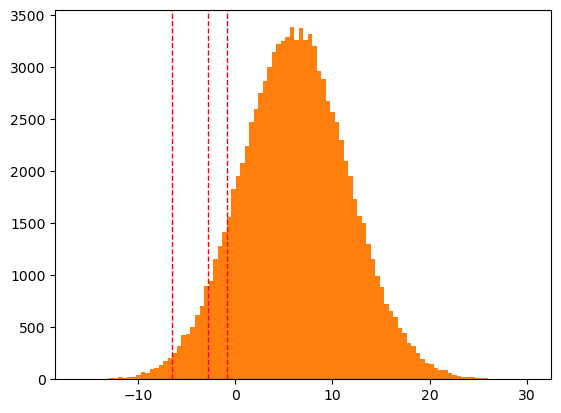

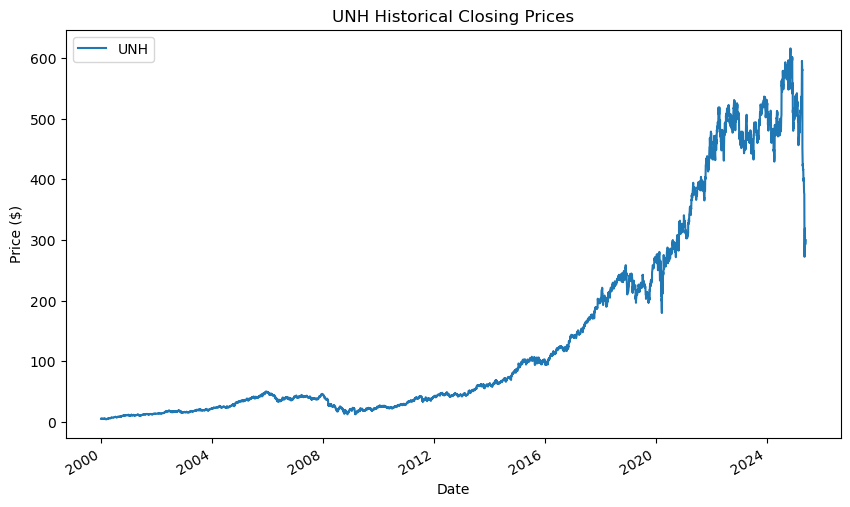

In [50]:
# Extract data from Yahoo Finance
data = yf.Ticker(ticker) 
stock_data = pd.DataFrame()
stock_data[ticker] = yf.download(ticker, start='2000-1-1', end='2025-05-31')['Close']

# Plot closing prices
stock_data.plot(figsize=(10, 6))
plt.title(f"{ticker} Historical Closing Prices")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.show()

## Distributions - Calculate Historical Returns and Statistical Measures

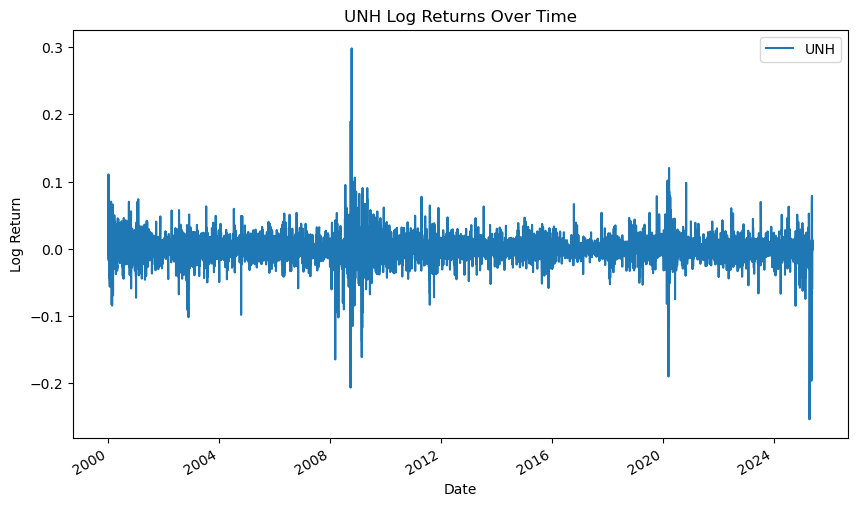

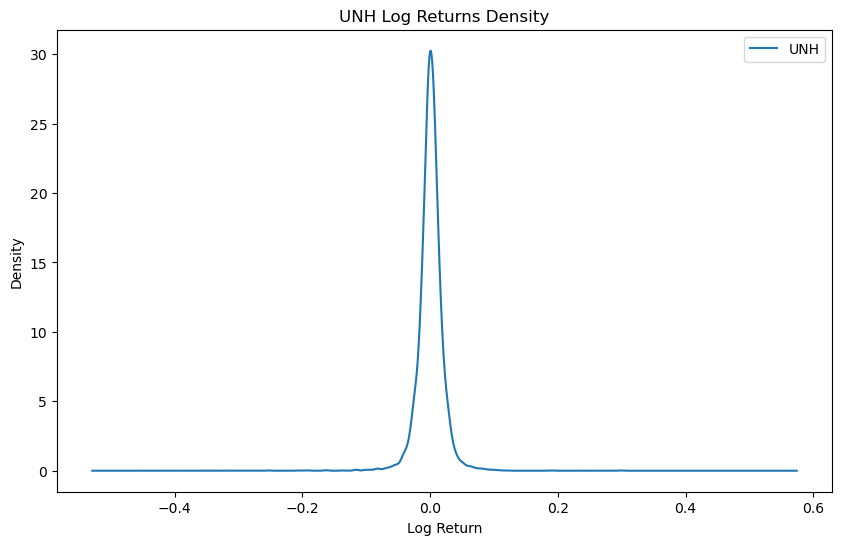

In [6]:
# Calculate historical log returns
log_returns = np.log(1 + stock_data.pct_change())

# Show log returns over time
log_returns.plot(figsize=(10, 6))
plt.title(f"{ticker} Log Returns Over Time")
plt.ylabel("Log Return")
plt.xlabel("Date")
plt.show()

# Show the distribution (density) of log returns
log_returns.plot.density(figsize=(10, 6))
plt.title(f"{ticker} Log Returns Density")
plt.xlabel("Log Return")
plt.show()

In [7]:
# Calculate key statistic measures
mean = log_returns.mean()
variance = log_returns.var()
STD = log_returns.std()

## Simulations - Simulate Future Daily Returns and Future Prices

In [8]:
# How to generate 10,000 random numbers betwen 0 and 1.
random_numbers = np.random.rand(10000)

# Use those randomly generated numbers to sample from a normal distribution
normal_random_numbers = norm.ppf(random_numbers)


In [9]:
# Simulate future daily returns using the above method
t_intervals = 250 
simulations = 10000

daily_logreturns_simulated = STD.values * norm.ppf(np.random.rand(t_intervals, simulations))
daily_simplereturns_simulated = np.exp(daily_logreturns_simulated)
daily_simplereturns_simulated.shape

(250, 10000)

In [10]:
# Using returns, calculate future price progression in each simulation

# Latest known stock price
last_price = stock_data.iloc[-1]

# Prepare an array for the price simulations
price_list = np.zeros_like(daily_simplereturns_simulated)

# Set the first row to the starting stock price
price_list[0] = last_price

price_list

array([[299.78189087, 299.78189087, 299.78189087, ..., 299.78189087,
        299.78189087, 299.78189087],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [11]:
# Calculate drift
drift = mean - (0.5*variance)

# Simulate future daily returns
t_intervals = 250
simulations = 10000

daily_logreturns_simulated = STD.values * norm.ppf(np.random.rand(t_intervals, simulations))
daily_logreturns_simulated_withdrift = daily_logreturns_simulated +drift.values
daily_simplereturns_simulated_withdrift = np.exp(daily_logreturns_simulated_withdrift)

In [12]:
# Apply a for loop for simulated prices
for t in range(1, t_intervals):
    price_list[t] = price_list[t - 1] * daily_simplereturns_simulated[t]

### Include Drift

In [13]:
# Calculate drift
drift = mean - (0.5*variance)

# Simulate future daily returns
t_intervals = 250
simulations = 10000

daily_logreturns_simulated = STD.values * norm.ppf(np.random.rand(t_intervals, simulations))
daily_logreturns_simulated_withdrift = daily_logreturns_simulated +drift.values
daily_simplereturns_simulated_withdrift = np.exp(daily_logreturns_simulated_withdrift)

In [14]:
# Create a variable for the latest price 
last_price = stock_data.iloc[-1]

# Prepare an array for the price simulations
price_list = np.zeros_like(daily_simplereturns_simulated_withdrift)

# Set the first row to the starting stock price
price_list[0] = last_price

# Apply a for loop for simulated prices
for t in range(1, t_intervals):
    price_list[t] = price_list[t - 1] * daily_simplereturns_simulated_withdrift[t]

## Quantifications - worst, average, best scenarios and the probability distribution

In [15]:
# Calculate worst, avg and best scenarios
WorstSim = round(price_list[-1].min(),2)
AvgSim = round(price_list[-1].mean(),2)
BestSim = round(price_list[-1].max(),2)

# Examine the worst, average, and best stock price sceanrios
print("Best and Worst Cases")
print(f"Worst Simulation $/share: {WorstSim}")
print(f"Avg Simulation $/share: {AvgSim}")
print(f"Best Simulation $/share: {BestSim}")

# Set up confidence intervals

Mean_Day250Prices = price_list[-1].mean()
SD_Day250Prices = price_list[-1].std()
UpperInterval_1SD = Mean_Day250Prices + 1 * SD_Day250Prices 
LowerInterval_1SD = Mean_Day250Prices - 1 * SD_Day250Prices
UpperInterval_2SD = Mean_Day250Prices + 2 * SD_Day250Prices
LowerInterval_2SD = Mean_Day250Prices - 2 * SD_Day250Prices

# Print out the price range within the confidence intervals
print("\n" + "Confidence Intervals")
print(f"1 Sigma (1 S.D): 68% confident that price after 250 days will fall between: ${LowerInterval_1SD} and ${round(UpperInterval_1SD,2)}")
print(f"2 Sigma (2 S.D): 95% confident that price after 250 days will fall between: ${round(LowerInterval_2SD, 2)} and ${round(UpperInterval_2SD, 2)}")

Best and Worst Cases
Worst Simulation $/share: 109.65
Avg Simulation $/share: 350.99
Best Simulation $/share: 1188.31

Confidence Intervals
1 Sigma (1 S.D): 68% confident that price after 250 days will fall between: $236.81049432955854 and $465.16
2 Sigma (2 S.D): 95% confident that price after 250 days will fall between: $122.63 and $579.34


Stock price source: https://finviz.com/quote.ashx?t=UNH&p=d#statements

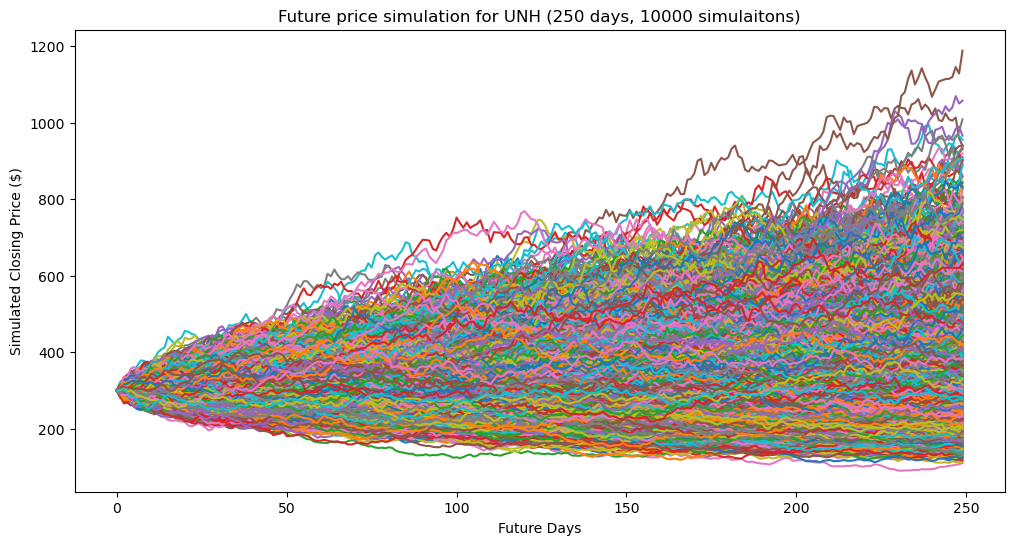

Best and worst scenario after 250 days:
Worst simulation $/share: 109.65
Average simulation $/share: 350.99
Best simulation $/share: 1188.31


In [16]:
# Graph simulations
plt.figure(figsize=(12,6))
plt.plot(price_list)
plt.title(f'Future price simulation for {ticker} (250 days, {simulations} simulaitons)')
plt.xlabel('Future Days')
plt.ylabel('Simulated Closing Price ($)')
plt.show()

# Summary Statistics at Day 250
WorstSim = round(price_list[-1].min(), 2)
AvgSim = round(price_list[-1].mean(), 2)
BestSim = round(price_list[-1].max(), 2)

print("Best and worst scenario after 250 days:")
print(f"Worst simulation $/share: {WorstSim}")
print(f"Average simulation $/share: {AvgSim}")
print(f"Best simulation $/share: {BestSim}")

# Value at Risk Assessment Model

### Distributions - Set Up Stock Parameters

In [17]:
# Number of shares
shares = 1

# Live stock price
price = yf.Ticker(ticker)
price = price.history().tail(1)['Close'].iloc[0]

print(price)
print('---------')
print(price)

308.54998779296875
---------
308.54998779296875


In [18]:
# Investment value
value = price * shares

# Risk free rate (one year treasury bill rate)
rfr = 0.0396 

# Volatility (30-day volatility at that time)
vol = .0247

print(f"Monthly volatility: {vol:.4f} ({vol*100:.2f}%)")

Monthly volatility: 0.0247 (2.47%)


30-day Historical volatility source: https://finviz.com/quote.ashx?t=UNH&p=d#statements

### Simulations - Calculate Investment Returns

In [19]:
# Number of simulations
simulations = 100000 

# Investment time in a year
t = (21 / 252)*6

In [20]:
# Explain np.random.standard_normal
sample = np.random.standard_normal(5000)
plt.hist(sample,bins=100)

(array([  2.,   1.,   1.,   0.,   0.,   0.,   3.,   2.,   1.,  10.,   4.,
          9.,  10.,   9.,   6.,  14.,  11.,  23.,  26.,  12.,  25.,  21.,
         42.,  33.,  43.,  49.,  47.,  55.,  60.,  86.,  74.,  76.,  86.,
         91.,  98., 112., 107., 118., 137., 116., 126., 127., 124., 157.,
        141., 159., 155., 127., 140., 163., 151., 136., 136., 113., 115.,
        107., 111., 112., 102.,  90.,  79.,  87.,  70.,  69.,  63.,  55.,
         49.,  38.,  41.,  35.,  25.,  19.,  26.,  23.,  17.,  12.,  13.,
         11.,  14.,  13.,   7.,   9.,   1.,   0.,   4.,   2.,   0.,   1.,
          0.,   2.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([-3.38568496, -3.31184199, -3.23799902, -3.16415605, -3.09031309,
        -3.01647012, -2.94262715, -2.86878418, -2.79494121, -2.72109825,
        -2.64725528, -2.57341231, -2.49956934, -2.42572637, -2.35188341,
        -2.27804044, -2.20419747, -2.1303545 , -2.05651154, -1.98266857,
        -1.9088256 , -1.83

In [21]:
print(np.mean(sample))
print(np.std(sample))

0.028852464705880685
1.0116631966443301


In [22]:
# Create a function to calculate the returns of the investment
def VaR(pv, rfr, vol, t, simulations):
    end_value = pv * np.exp((rfr - .5 * vol ** 2) * t + np.random.standard_normal(
        simulations) * vol * np.sqrt(t))
    returns = end_value - pv
    return returns

# Apply the VaR function to simulate the returns
returns = VaR(value, rfr, vol, t, simulations)


### Quantifications - Identify VaR at 90%, 95%, and 99% Confidence Level

In [23]:
# Plot the returns
plt.hist(returns, bins=100);

# Show VaR at 90%, 95%, and 99% confidence level
percentiles = [10,5,1]

for i in percentiles:
    confidence = (100-i)/100
    value = np.percentile(returns, i)
    print("VaR at {:.0%} confidence level: ${:,.0f}".format(confidence, value))
    plt.axvline(value, color = 'red', linestyle='dashed', linewidth=1)

VaR at 90% confidence level: $-1
VaR at 95% confidence level: $-3
VaR at 99% confidence level: $-6


# Net Income Forecast

### Distributions - Assumptions

In [24]:
income_statement_combined, balance_sheet_combined, cash_flow_combined = get_financial_data(ticker)

# Define
COGS_mean = income_statement_combined.loc["COGS", "Mean"]
COGS_std = income_statement_combined.loc["COGS", "Std Dev"]

sales_mean = income_statement_combined.loc["Sales", "Mean"]
sales_std = income_statement_combined.loc["Sales", "Std Dev"]

# Convert to percentage
COGS_pct_mean = COGS_mean / sales_mean  
COGS_pct_std = COGS_std / sales_mean  

# Print results
print("\n--- Cost of Goods Sold Analysis ---")
print(f"COGS Mean: ${COGS_mean:,.0f}")
print(f"COGS Std Dev: ${COGS_std:,.0f}")
print(f"Sales Mean: ${sales_mean:,.0f}")
print(f"COGS as % of Sales (Mean): {COGS_pct_mean:.2%}")
print(f"COGS as % of Sales (Std Dev): {COGS_pct_std:.2%}")


--- Cost of Goods Sold Analysis ---
COGS Mean: $274,784,400,000
COGS Std Dev: $43,350,183,077
Sales Mean: $358,743,200,000
COGS as % of Sales (Mean): 76.60%
COGS as % of Sales (Std Dev): 12.08%


### Simulations - Simulate Sales, COGS, and Net Income

In [25]:
# Generate sales samples 
simulations = 10000
sales_sims = np.random.normal(sales_mean, sales_std, simulations)

print("mean:", np.mean(sales_sims))
print("std:", np.std(sales_sims))

mean: 359023784091.33777
std: 51453704926.15121


In [26]:
income, balance, cashflow = get_financial_data(ticker)

# Simulation of COGS as a Percentage of Sales
COGS_pct_sims = np.random.normal(COGS_pct_mean, COGS_pct_std, simulations)
COGS_sims = - (sales_sims * COGS_pct_sims)

# (Optional) Other Expenses
operating_expense_mean = income_statement_combined.loc["Operating Expenses", "Mean"]
operating_expense_pct = operating_expense_mean/sales_mean
operating_expenses_sims = - (sales_sims * operating_expense_pct)


# (Optional) Taxes
EBT = sales_sims + COGS_sims + operating_expenses_sims  # Earnings Before Taxes
tax_rate_mean = operating_expense_mean = income_statement_combined.loc["Effective Tax Rate", "Mean"]
taxes = - (EBT * tax_rate_mean)

# Generate net income simulations
profit_sims = sales_sims + COGS_sims  

print("\n--- Simulated COGS ---")
print(f"Simulated average COGS: ${-COGS_sims.mean():,.0f}")
print(f"Simulated COGS as % of Sales: {COGS_pct_sims.mean():.2%}")

print("\n--- Simulated Operating Expenses ---")
print(f"Operating expenses as % of Sales: {operating_expense_pct:.2%}")
print(f"Simulated average Operating Expenses: ${-operating_expenses_sims.mean():,.0f}")

print("\n--- Simulated Taxes ---")
print(f"Average Effective Tax Rate: {tax_rate_mean:.2%}")
print(f"Simulated average taxes: ${-taxes.mean():,.0f}")

print("\n--- Simulated Net Income ---")
print(f"Simulated average Net Income: ${profit_sims.mean():,.0f}")
print(f"Minimum Net Income (worst case): ${profit_sims.min():,.0f}")
print(f"Maximum Net Income (best case): ${profit_sims.max():,.0f}")


--- Simulated COGS ---
Simulated average COGS: $274,934,509,380
Simulated COGS as % of Sales: 76.60%

--- Simulated Operating Expenses ---
Operating expenses as % of Sales: 15.01%
Simulated average Operating Expenses: $53,895,920,713

--- Simulated Taxes ---
Average Effective Tax Rate: 21.07%
Simulated average taxes: $6,360,309,838

--- Simulated Net Income ---
Simulated average Net Income: $84,089,274,711
Minimum Net Income (worst case): $-117,115,909,132
Maximum Net Income (best case): $279,361,202,520


### Quantifications - Examine the Worst, Average, Best scenarios and the Probability Distribution

In [27]:
# Examine the worst, average, and best cases
print("Worst case:", min(profit_sims))
print("Average case:", profit_sims.mean())
print("Best case:", max(profit_sims))

Worst case: -117115909131.86646
Average case: 84089274711.00383
Best case: 279361202520.004


In [28]:
# Set up confidence intervals
upper68 = profit_sims.mean()+profit_sims.std()
lower68 = profit_sims.mean()-profit_sims.std()
upper95 = profit_sims.mean()+profit_sims.std()*2
lower95 = profit_sims.mean()-profit_sims.std()*2

# Print out confidence intervals
print(f"68% profit range: ${round(lower68,2)} and ${round(upper68,2)}")
print(f"95% profit range: ${round(lower95,2)} and ${round(upper95,2)}")

68% profit range: $38594751751.55 and $129583797670.46
95% profit range: $-6899771207.91 and $175078320629.92


# Capital Investment NPV Forecast 

### Simulate Variables 

In [29]:
income_statement_combined, balance_sheet_combined, cash_flow_combined = get_financial_data(ticker)
stock = yf.Ticker(ticker)
# Simulate Discount Rates (outside the loop)
depreciation_mean = income_statement_combined.loc["Depreciation", "Mean"]
WC_mean = balance_sheet_combined.loc["Working Capital", "Mean"]
market_return = 0.08 #S&P500
beta = stock.info.get("beta", np.nan)
discRate_mean = rfr + beta * (market_return - rfr)
discRate_std = 0.02
discRate_sim = np.random.normal(discRate_mean, discRate_std, simulations)
discRate_sim = np.clip(discRate_sim, 0.01, 0.30)

# Create a list to contain all NPV simulations
npv=[]

# Create a for loop to go through 10,000 simulations
for i in np.arange(simulations):
    
    # Calculate NOPAT(net operating profit after taxes)
    EBIT_sims = sales_sims + COGS_sims - operating_expenses_sims
    NOPAT_sims = EBIT_sims * (1 - tax_rate_mean)
    
    # Calculate FCF (free cash flow)
    fcf_sims = NOPAT_sims + depreciation_mean - WC_mean

    # Constant cash flow for 5 years (or adjust if your projection structure varies)
    fcf_years = np.ones(5) * fcf_sims[i]
    
     # Calculate NPV
    R = discRate_sim[i]
    npvProject = npf.npv(R, fcf_years)
    
    # Add npvProject to the list of all NPV simulations
    npv.append(npvProject)

print("\n--- Monte Carlo Simulation: Project NPV ---")
print(f"Mean NPV: ${np.mean(npv):,.2f}")
print(f"Median NPV: ${np.median(npv):,.2f}")
print(f"5th percentile NPV (conservative): ${np.percentile(npv, 5):,.2f}")
print(f"95th percentile NPV (optimistic): ${np.percentile(npv, 95):,.2f}")
print(f"Minimum NPV: ${np.min(npv):,.2f}")
print(f"Maximum NPV: ${np.max(npv):,.2f}")




--- Monte Carlo Simulation: Project NPV ---
Mean NPV: $598,023,492,884.52
Median NPV: $587,966,094,248.37
5th percentile NPV (conservative): $336,669,707,559.06
95th percentile NPV (optimistic): $895,008,174,770.63
Minimum NPV: $-39,682,867,670.91
Maximum NPV: $1,423,581,054,962.68


In [30]:
print(discRate_mean)

0.0579012


# Valuations

Multiples: P/E, P/B, and P/S

In [31]:
income, balance, cashflow = get_financial_data(ticker)

# Revenue Per Share" is available inside income_stmt
print(income.loc["Revenue Per Share"])

TTM       441.40
2021      300.83
2022      341.22
2023      396.19
2024      430.87
Mean      382.10
Std Dev    59.93
Name: Revenue Per Share, dtype: float64


In [38]:
income, balance, cashflow = get_financial_data(ticker)

# Get key statistics
info = yf.Ticker(ticker).info
# Current stock price
current_price = info['currentPrice']
# Valuation by P/E
pe_valuation = float(income.loc['EPS', 'TTM']) * float(pe_ratio)
# Valuation by P/B
pb_valuation = float(balance.loc['Book Value per Share', 'TTM']) * float(pb_ratio)
# Valuation by P/S
ps_valuation = float(income.loc['Revenue Per Share', 'TTM']) * float(ps_ratio)
# Print results
print(f"Current price: ${round(current_price, 2)}")

print("----- Valuations using multiples -----")
if pe_valuation: print(f"Valuation P/E: ${round(pe_valuation, 2)}")
if pb_valuation: print(f"Valuation P/B: ${round(pb_valuation, 2)}")
if ps_valuation: print(f"Valuation P/S: ${round(ps_valuation, 2)}")

Current price: $308.55
----- Valuations using multiples -----
Valuation P/E: $307.34
Valuation P/B: $332.37
Valuation P/S: $300.15


In [39]:
print("----- Valuations using multiples -----")

if pe_valuation:
    print(f"P/E Valuation = EPS ({income.loc['EPS', 'TTM']}) * P/E ratio ({pe_ratio}) = ${float(income.loc['EPS', 'TTM']) * float(pe_ratio):.2f}")
if pb_valuation:
    print(f"P/B Valuation = Book Value per Share ({balance.loc['Book Value per Share', 'TTM']}) * P/B ratio ({pb_ratio}) = ${float(balance.loc['Book Value per Share', 'TTM']) * float(pb_ratio):.2f}")
if ps_valuation:
    print(f"P/S Valuation = Revenue per Share ({income.loc['Revenue Per Share', 'TTM']}) * P/S ratio ({ps_ratio}) = ${float(income.loc['Revenue Per Share', 'TTM']) * float(ps_ratio):.2f}")

----- Valuations using multiples -----
P/E Valuation = EPS (23.88) * P/E ratio (12.87) = $307.34
P/B Valuation = Book Value per Share (113.20667384284177) * P/B ratio (2.936) = $332.37
P/S Valuation = Revenue per Share (441.3961248654467) * P/S ratio (0.68) = $300.15


## Discounted Cash Flow

### Calculate WACC

In [33]:
income, balance, cashflow = get_financial_data(ticker)

# WACC Calculation and Simulation Preparation
cost_equity = rfr + beta * (market_return - rfr)
weight_debt = debt_equity_ratio / (1 + debt_equity_ratio)
weight_equity = 1 - weight_debt
cost_debt = income_statement_combined.loc["Interest Expense", "Mean"] / balance_sheet_combined.loc["Total Debt", "Mean"]
WACC = weight_equity * cost_equity + weight_debt * cost_debt * (1 - income_statement_combined.loc["Effective Tax Rate", "Mean"])
tax_rate = income_statement_combined.loc["Effective Tax Rate", "Mean"]


# Print WACC formula header
print("WACC Formula:")

# Display WACC formula in LaTeX format
wacc_formula = (
    r"\text{WACC} = "
    f"{weight_equity:.4f} \\cdot {cost_equity:.4f} + "
    f"{weight_debt:.4f} \\cdot {cost_debt:.4f} \\cdot (1 - {tax_rate:.4f})"
)
display(Math(wacc_formula))

# Print calculated WACC
print(f"Calculated WACC: {WACC:.4f}")

WACC Formula:


<IPython.core.display.Math object>

Calculated WACC: 0.0485


Confirm WACC here and compare with competitors:https://www.gurufocus.com/term/wacc/UNH

### Calculate DCF

In [34]:
import numpy as np
import numpy_financial as npf

# Get financial data
income, balance, cashflow = get_financial_data(ticker)

# Ensure 10,000 simulations are ready
simulations = 10000
np.random.seed(42)

# Growth Rate
growth_rate = float(income.loc['Sales Growth', 'Mean'])  # Average sales growth
growth_rate_terminal = 0.025  # More realistic

# 1. Simulate WACC
WACC_sim = np.random.normal(WACC, 0.01, simulations)
WACC_sim = np.clip(WACC_sim, float(income.loc['Sales Growth', 'Mean']) + 0.001, 0.30)

# 2. Simulate EBIT and NOPAT
EBIT_sims = sales_sims + COGS_sims - float(income.loc['Operating Expenses', 'Mean'])
NOPAT_sims = EBIT_sims * (1 - float(income.loc['Effective Tax Rate', 'Mean']))

# 3. Calculate FCF (without inflating by 1000 or re-simulating here)
fcf_sims = NOPAT_sims + float(income.loc['Depreciation', 'Mean']) - WC_mean

# Limit FCF to a realistic range (e.g., between 0 and 40B)
fcf_sims = np.clip(fcf_sims, 2000000000, 40000000000)

# 4. Calculate DCF valuation with growth
dcf_valuations = []

for i in range(simulations):
    r = WACC_sim[i]
    fcf = fcf_sims[i]

    # Project FCF for 5 years
    fcf_proj = [fcf * (1 + growth_rate) ** t for t in range(1, 6)]

    # Calculate terminal value in year 5
    terminal_value = fcf_proj[-1] * (1 + growth_rate_terminal) / (r - growth_rate_terminal)

    # Add terminal value to the last cash flow
    fcf_proj[-1] += terminal_value

    # Calculate NPV (includes everything)
    dcf = npf.npv(r, fcf_proj)
    dcf_valuations.append(dcf)

# 5. Divide by number of shares to get value per share
dcf_array = np.array(dcf_valuations)
dcf_per_share = dcf_array / float(income.loc['Shares Outstanding', 'TTM'])

# 6. Display results
print("\n--- DCF Results per Share ---")
print(f"Minimum value: ${dcf_per_share.min():.2f}")
print(f"Average value: ${dcf_per_share.mean():.2f}")
print(f"Maximum value: ${dcf_per_share.max():.2f}")


--- DCF Results per Share ---
Minimum value: $49.25
Average value: $763.63
Maximum value: $984.95


In [35]:
# 1. Ensure all variables are ready
dcf_valuation = dcf_per_share.mean()

# 2. Build dictionary automatically
valuations = {}
if pe_valuation: valuations['P/E'] = pe_valuation
if pb_valuation: valuations['P/B'] = pb_valuation
if ps_valuation: valuations['P/S'] = ps_valuation
valuations['DCF'] = dcf_valuation

# 3. Averages
average_valuation = np.mean(list(valuations.values()))

# You can adjust weights if you want to give more weight to DCF (e.g., 0.1, 0.1, 0.1, 0.7)
weights = np.array([1 / len(valuations)] * len(valuations))
weighted_avg = np.average(list(valuations.values()), weights=weights)

# 4. Sensitivity ±10%
sensitivity_ranges = {method: (val * 0.9, val * 1.1) for method, val in valuations.items()}
avg_min = np.mean([val[0] for val in sensitivity_ranges.values()])
avg_max = np.mean([val[1] for val in sensitivity_ranges.values()])

# 5. Upside function
def calculate_upside(valuation):
    return ((valuation - current_price) / current_price) * 100

# --- Display Results ---
print("=== COMPLETE VALUATION ANALYSIS ===")
print("\n--- Individual Valuations ---")
for method, val in valuations.items():
    print(f"{method}: ${val:.2f} ({calculate_upside(val):.2f}% upside)")

print("\n--- Consolidated Metrics ---")
print(f"Simple Average: ${average_valuation:.2f} ({calculate_upside(average_valuation):.2f}% upside)")
print(f"Weighted Average: ${weighted_avg:.2f} ({calculate_upside(weighted_avg):.2f}% upside)")
print(f"Sensitivity Range (±10%): ${avg_min:.2f} - ${avg_max:.2f}")
print(f"Current Price: ${current_price:.2f}")

# Conclusions text
print(f"\nCurrent price: ${current_price:.2f}")
decision = "✅ Good investment opportunity (valuation > current price)" if average_valuation > current_price else "❌ Not a good investment (valuation ≤ current price)"
print(f"Decision: {decision}")

=== COMPLETE VALUATION ANALYSIS ===

--- Individual Valuations ---
P/E: $307.34 (-0.39% upside)
P/B: $332.37 (7.72% upside)
P/S: $300.15 (-2.72% upside)
DCF: $763.63 (147.49% upside)

--- Consolidated Metrics ---
Simple Average: $425.87 (38.02% upside)
Weighted Average: $425.87 (38.02% upside)
Sensitivity Range (±10%): $383.29 - $468.46
Current Price: $308.55

Current price: $308.55
Decision: ✅ Good investment opportunity (valuation > current price)


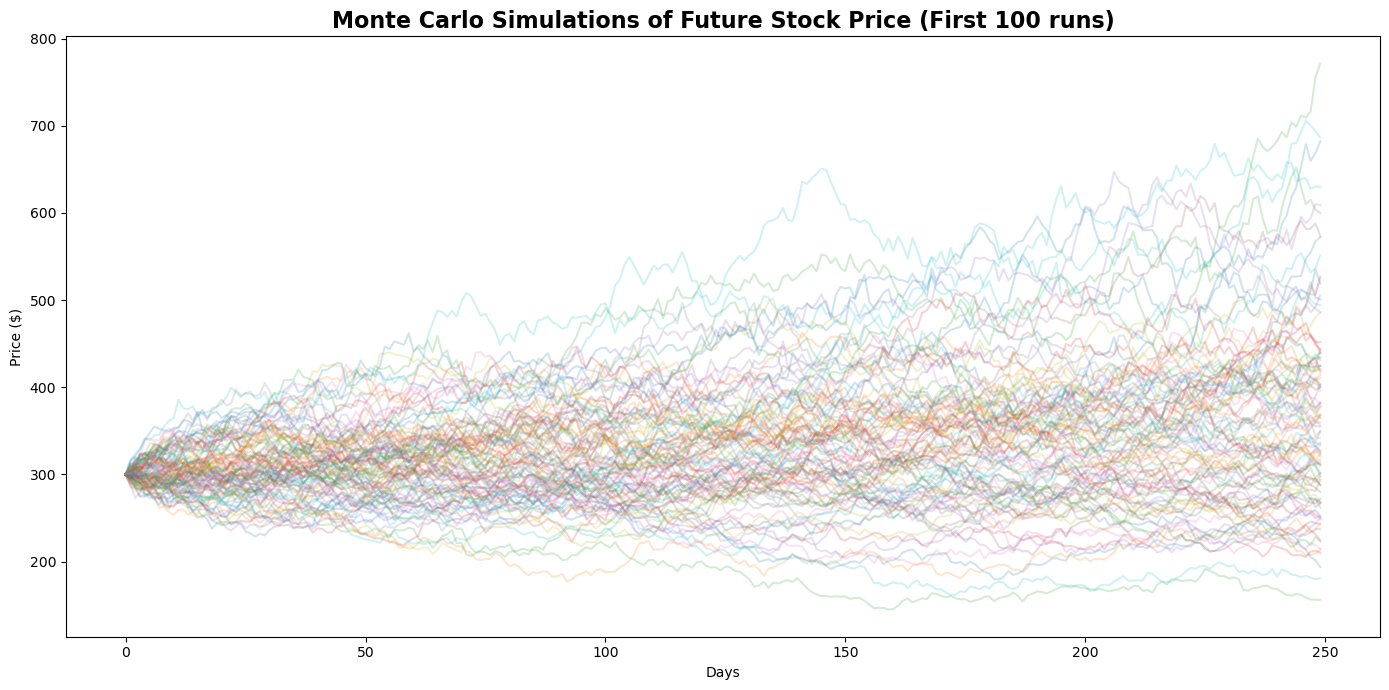

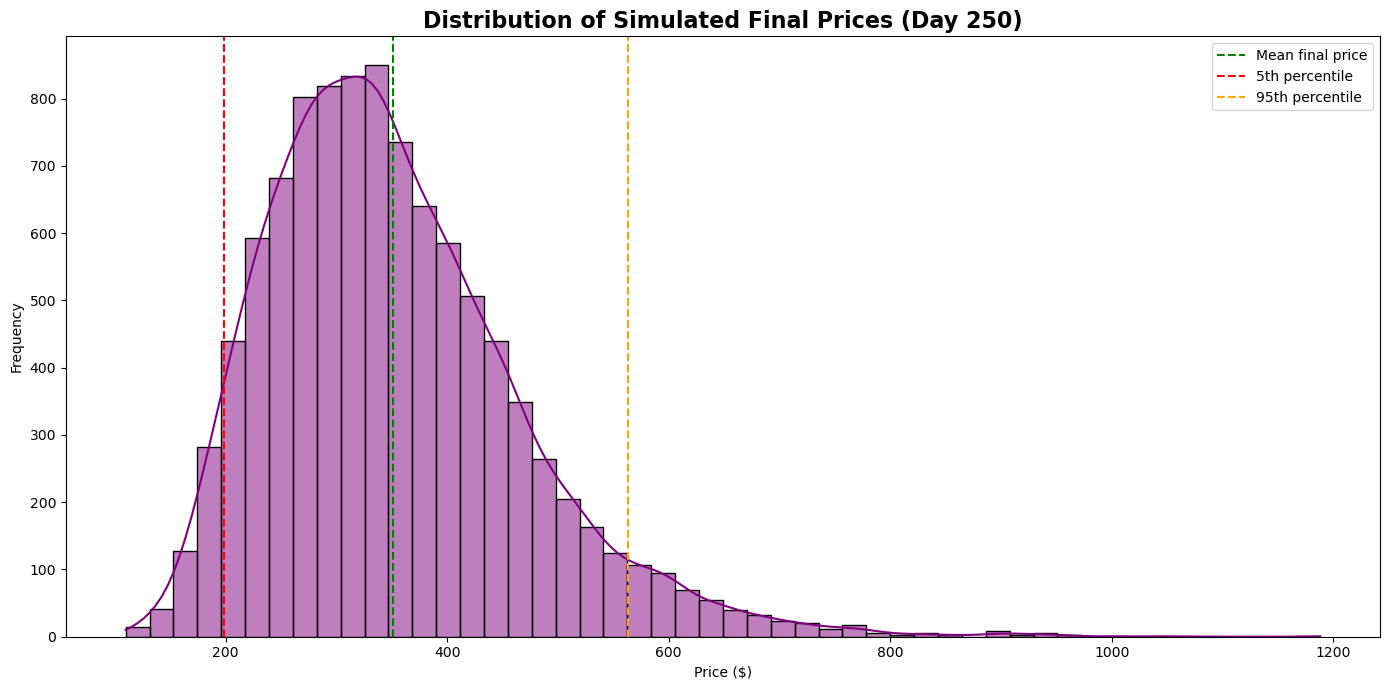

In [51]:
# Define final_prices from price_list (from your stock price simulation)
final_prices = price_list[-1]  # Last row of price_list contains prices at day 250

# Plots
plt.figure(figsize=(14,7))
for i in range(100):  # Plot only first 100 simulations for clarity
    plt.plot(price_list[:, i], alpha=0.2)
plt.title('Monte Carlo Simulations of Future Stock Price (First 100 runs)', fontsize=16, fontweight='bold')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,7))
sns.histplot(final_prices, bins=50, color='purple', kde=True)
plt.axvline(final_prices.mean(), color='green', linestyle='--', label='Mean final price')
plt.axvline(np.percentile(final_prices, 5), color='red', linestyle='--', label='5th percentile')
plt.axvline(np.percentile(final_prices, 95), color='orange', linestyle='--', label='95th percentile')
plt.title('Distribution of Simulated Final Prices (Day 250)', fontsize=16, fontweight='bold')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()